# Анализ тональности текста

# 1. Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from bs4 import BeautifulSoup

import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Embedding
from keras import utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

2024-01-22 10:04:46.266183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 10:04:46.301637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Настройка параметров

In [2]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision",6)
pd.set_option("plotting.backend", "matplotlib")
warnings.simplefilter("ignore")

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline
# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

# 3. Код (вспомогательные методы)

In [3]:
RANDOM_STATE = 42
PUNCTUATION_MARKS = ['!', ',', '(', ')', ':', '-', '?', '.', '..', '...', '«', '»', ';', '–', '--']

LOCAL_URI = './data/'
NLTK_DIR='/var/lib/python/python_venvs/nlp_env/lib/nltk_data/'


def remove_URL(processed_text):
    """
    Удаление в тексте строк URL
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', processed_text)


def strip_html(processed_text):
    """
    Удаление в тексте HTML-тегов
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    soup = BeautifulSoup(processed_text, "html.parser")
    return soup.get_text()


def remove_between_square_brackets(processed_text):
    """
    Удаление текста в квадратных скобках
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    return re.sub('\[[^]]*\]', '', processed_text)


def clean_chars_with_regex(processed_text):
    """
    Удаление в тексте различных символов с помощью регулярных выражений
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    pattern = re.compile(r'[â]')
    clean_string = re.sub(pattern, '', processed_text)
    return clean_string


def remove_emoji(processed_text):
    """
    Удаление в тексте эмодзи
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', processed_text)


def remove_names(processed_text):
    """
    Удаление в тексте специальных символов
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    pattern = r'\S*(@|#)\S+'
    processed_text = re.sub(pattern, '', processed_text)
    return processed_text


def remove_numbers(processed_text):
    """
    Удаление в тексте чисел
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    pattern = r'\s\d+\s'
    processed_text = re.sub(pattern, ' ', processed_text)
    return processed_text


def remove_special_characters(processed_text):
    """
    Удаление в тексте специальных символов
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    pattern = r'[^a-zA-z0-9\s?]'
    processed_text = re.sub(pattern, '', processed_text)
    return processed_text


def convert_abbrev(processed_text):
    """
    Замена сокращений
    :param processed_text: обрабатываемый текст
    :return: обработанный текст
    """
    abbreviations = {
    "u": "you",
    "r": "are",
    "pic": "picture"
    }
    return abbreviations[processed_text.lower()] \
        if processed_text.lower() in abbreviations.keys() \
        else processed_text


def preprocess(processed_text, stop_words, punctuation_marks, morph):
    """
    Предобработка текста перед кодированием
    :param processed_text: обрабатываемый текст
    :param stop_words: список стоп-слов
    :param punctuation_marks: список знаков пунктуации
    :param morph: морфологический анализатор
    :return:обработанный текст
    """

    processed_text=remove_URL(processed_text)
    processed_text=strip_html(processed_text)
    processed_text=remove_names(processed_text)
    processed_text=remove_numbers(processed_text)
    processed_text=remove_between_square_brackets(processed_text)
    processed_text=clean_chars_with_regex(processed_text)
    processed_text=remove_emoji(processed_text)
    processed_text=remove_special_characters(processed_text)
    processed_text=convert_abbrev(processed_text)

    tokens = word_tokenize(processed_text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            
            lemma = morph.parse(token)[0].normal_form
            if lemma not in stop_words:
                preprocessed_text.append(lemma)

    return preprocessed_text


def naiv_predict(token_list, keywords_dict ):
    """
    Классификация текста с использованием эвристики
    :param token_list: список токенов, заменяющих текст
    :param keywords_dict: словарь слов, ключевых для разных классов
    :return: предсказанный класс
    """

    # Словарь для подсчета совпадений слов
    class_counts = {k: 0 for k in keywords_dict.keys()}

    # Проходимся по каждому классу и подсчитываем количество ключевых слов
    for class_name, words in keywords_dict.items():
        for word in words:
            if word in token_list:
                class_counts[class_name] += 1

    # Определение класса с максимальным количеством ключевых слов
    predicted_class = max(class_counts, key=class_counts.get)

    return predicted_class


def text_to_sequence(word_list, word_to_index_dict, unknown_code):
    """
    Преобразование текста в список кодов слов этого текста
    :param word_list: список слов, входящих в текст
    :param word_to_index_dict: словарь, отображающий слова в коды
    :param unknown_code: код для неизвестного слова
    :return: список числовых кодов
    """
    seq = []

    for word in word_list:
        index = word_to_index_dict.get(word, unknown_code)
        # Неизвестные слова не добавляем в выходную последовательность
        if index != unknown_code:
            seq.append(index)

    return seq


def vectorize_sequences(sequences, dimension=10000):
    """
    Создание мешка слов
    :param sequences: список списков числовых кодов, представляющих тексты
    :param dimension: количество токенов для анализа
    :return: список векторизованных представлений текстов
    """
    results = np.zeros((len(sequences), dimension))

    for i, sequence in enumerate(sequences):
        for index in sequence:
            results[i, index] += 1

    return results

def get_word_dictionaries(words_counter_obj):
    """
    Получение словарей для отображения даты в код и обратно
    :param words_counter_obj: объект счетчика слов
    :return: кортеж, состоящий из словаря, отображающего слова в коды, и словаря, отображающего коды в слова
    """
    # Словарь, отображающий слова в коды
    word_to_index = dict()
    # Словарь, отображающий коды в слова
    index_to_word = dict()
    i=2
    for word in words_counter_obj.most_common():
        if not word[0].isdigit():
            word_to_index[word[0]] = i
            index_to_word[i] = word[0]
            i+=1
            if i>=max_words:
                break

    return word_to_index,index_to_word

# 4. Загрузка и подготовка данных

In [4]:
datafile = LOCAL_URI + 'train.csv'
df = pd.read_csv(datafile,  low_memory=False)

# 5. Исследовательский анализ данных (exploratory data analysis - EDA)

In [5]:
df.sample(7)

,Unnamed: 0,Text,Sentiment
9609,9609,Obamacare is turning 10 years old amid the pan...,Neutral
36697,36696,https://t.co/ffa4XTiBT3. Relating to COVID-19....,Positive
35607,35606,I guess he ran out of TP.\r\r\nIt has begun.\r...,Neutral
3013,3013,With empty grocery shelves as the new norm IÂ...,Positive
32602,32602,South Simcoe #Realtor says #COVID19 pandemic s...,Neutral
16384,16384,Opinion | Banks Should Defer Household Debt to...,Negative
25372,25372,If you are worried about being evicted or fore...,Positive


Все тексты на английском языке. В текстах содержится много специальных символов, которые не нужны для дальнейшей обработки. Есть адреса сайтов, а также теги пользователей, начинающиеся с символов @ и #.  Их необходимо будет удалить.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41158 non-null  object
 1   Text        41158 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 964.8+ KB


In [7]:
df.Text.duplicated().sum()

0

In [8]:
df.isna().sum()

Unnamed: 0    1
Text          1
Sentiment     4
dtype: int64

Датасет содержит 3 столбца:
- Unnamed - безымянный - вероятно индекс строки;
- Text - строка для обработки;
- Sentiment - известное значение тональности для строки.
Всего 41159 записей, есть пропуски. Значения безымянного столбца нам не нужны. Это необходимо исправить.

In [9]:
df.drop(df.columns [0], axis= 1 , inplace= True)
df.dropna(inplace=True, ignore_index=True)
print(f"Пропусков в данных: {df.isna().sum()}")

Пропусков в данных: Text         0
Sentiment    0
dtype: int64


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Уникальных значений:

In [11]:
df.nunique()

Text         41155
Sentiment        5
dtype: int64

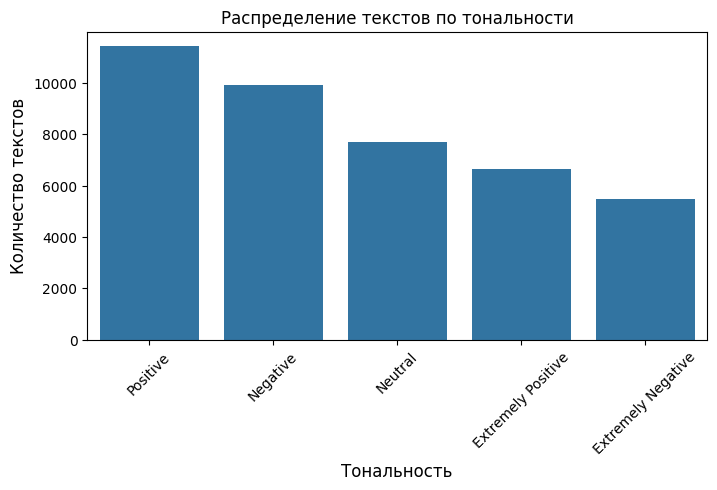

In [12]:
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Распределение текстов по тональности')
plt.ylabel('Количество текстов', fontsize=12)
plt.xlabel('Тональность', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Все тексты в наборе данных уникальны.
В датасете представлено 5 значений тональности:
- крайне позитивное (Extremely Positive)
- позитивное (Positive)
- нейтральное (Neutral)
- негативное (Negative)
- крайне негативное (Extremely Negative).
Больше всего текстов в позитивной тональности, меньше всего - в крайне негативной. Неравномерное распределение может привести к предвзятости модели. Выборка несбалансированная.

Длина текстов в символах

Максимальная длина текста:  355
Минимальная длина текста:  11
Средняя длина текста:  204


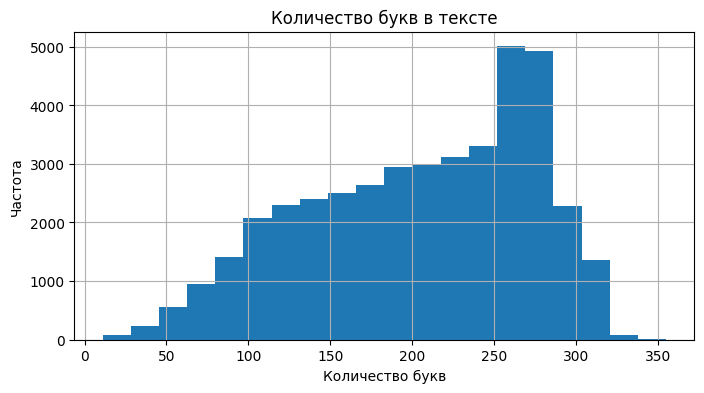

In [13]:
# Количество букв в каждом тексте
df["letter_count"]=df['Text'].apply(len)
print("Максимальная длина текста: ",df.letter_count.max())
print("Минимальная длина текста: ",df.letter_count.min())
print("Средняя длина текста: ",round(df.letter_count.mean()))
df.groupby('Sentiment')['letter_count'].describe()
plt.figure(figsize=(8, 4))
bins = 20
plt.hist(df['letter_count'], bins=bins)
plt.xlabel('Количество букв')
plt.ylabel('Частота')
plt.title('Количество букв в тексте')
plt.grid()
plt.show()

Длина текстов в словах

Максимальная длина текста:  64
Минимальная длина текста:  1
Средняя длина текста:  31
Медиана длины текста:  32


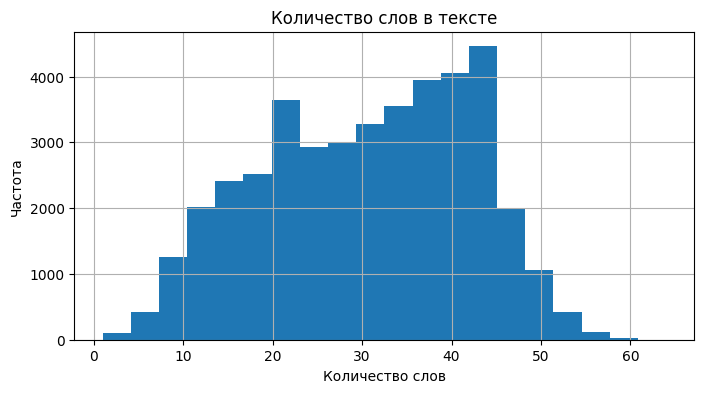

In [14]:
# Количество слов в каждом тексте
df['word_count']=df['Text'].astype(str).str.split().map(lambda x: len(x))
print("Максимальная длина текста: ",df.word_count.max())
print("Минимальная длина текста: ",df.word_count.min())
print("Средняя длина текста: ",round(df.word_count.mean()))
print("Медиана длины текста: ",round(df.word_count.median()))
df.groupby('Sentiment')['word_count'].describe()
plt.figure(figsize=(8, 4))
bins = 20
plt.hist(df['word_count'], bins=bins)
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.title('Количество слов в тексте')
plt.grid()
plt.show()

Общая статистика

In [15]:
df.describe()

,letter_count,word_count
count,41155.000000,41155.000000
mean,204.197692,30.500255
std,68.655884,11.591438
min,11.000000,1.000000
25%,151.000000,21.000000
50%,215.000000,32.000000
75%,259.000000,40.000000
max,355.000000,64.000000


В текстах от 1 до 64 слов, в среднем 30, верхнему квартилю соответствует значение 40.
Аналогично, в текстах от 11 до 355 символов, в среднем 204, верхнему квартилю соответствует значение 259.
Распределение длин текстов и в символах, и в словах, немного отличается от нормального, и наблюдается некоторое преобладание текстов с длиной 40-45 слов или 250-275 символов.

In [16]:
print("Всего символов: ", df.letter_count.sum())
print("Всего слов: ", df.word_count.sum())

Всего символов:  8403756
Всего слов:  1255238


Найдем символы, встречающиеся чаще всего в текстах

In [17]:
popular_letters=[]
for text in df.Text.values:
    popular_letters +=list(text)
popular_letters = pd.Series(popular_letters).value_counts(sort=True,ascending=False )
popular_letters.index.rename('letter', True)
print("Всего уникальных символов: ", popular_letters.nunique())
popular_letters.head(10)

Всего уникальных символов:  122


letter
     1206984
e     665408
o     543948
t     519411
a     457974
s     435881
r     424190
i     423395
n     404765
h     243726
Name: count, dtype: int64

Найдем слова, встречающиеся чаще всего в текстах

In [18]:
popular_words=[]
for text in df.Text.values:
    popular_words +=text.split()
popular_words = pd.Series(popular_words).value_counts(sort=True,ascending=False )
popular_words.index.rename('word', True)
print("Всего уникальных слов: ", popular_words.nunique())
popular_words.head(10)

Всего уникальных слов:  657


word
the             40342
to              37305
and             23076
of              21235
a               17935
in              17667
for             13309
#coronavirus    12224
is              11584
are             10783
Name: count, dtype: int64

Чаще всего используется символ пробела, а также буквы e, o, t, a, s, что соответствует общепринятой практике.
Из слов самые популярные оказались артикли, союзы, модальные глаголы и предлоги, что также ожидаемо для английского языка.
В целом тексты по своему составу достаточно стандартны, что позволяет использовать существующие обученные для
английского языка модели и библиотеки.

# 6. Предварительная обработка текста

In [19]:
nltk.download('punkt', download_dir=NLTK_DIR)
nltk.download('stopwords', download_dir=NLTK_DIR)

[nltk_data] Downloading package punkt to
[nltk_data]     /var/lib/python/python_venvs/nlp_env/lib/nltk_data/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /var/lib/python/python_venvs/nlp_env/lib/nltk_data/...
[nltk_data]   Package stopwords is already up-to-date!


True

Загрузка стоп-слов и морфологического анализатора

In [20]:
stop_words_eng = stopwords.words("english")

In [21]:
morph = pymorphy3.MorphAnalyzer()

Пример обработки текста

In [22]:
text = df.iloc[21]['Text']
text

'https://t.co/AVKrR9syff\r\r\n\r\r\nThe COVID-19 coronavirus pandemic is impacting consumer shopping behavior, purchase decisions and retail sales, according to a First Insight study.'

In [23]:
text1=preprocess(text, PUNCTUATION_MARKS, stop_words_eng, morph)
text1

['covid19',
 'coronavirus',
 'pandemic',
 'impacting',
 'consumer',
 'shopping',
 'behavior',
 'purchase',
 'decisions',
 'retail',
 'sales',
 'according',
 'first',
 'insight',
 'study']

Очистка, разделение текста на токены, морфологическая обработка токенов

In [24]:
df['Preprocessed_texts'] = df.apply(lambda row: preprocess(row['Text'], PUNCTUATION_MARKS, stop_words_eng, morph),  axis=1)

In [26]:
df.head()

,Text,Sentiment,letter_count,word_count,Preprocessed_texts
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,8,[]
1,advice Talk to your neighbours family to excha...,Positive,237,38,"[advice, talk, neighbours, family, exchange, p..."
2,Coronavirus Australia: Woolworths to give elde...,Positive,131,14,"[coronavirus, australia, woolworths, give, eld..."
3,My food stock is not the only one which is emp...,Positive,306,42,"[food, stock, one, empty, please, dont, panic,..."
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310,40,"[ready, go, supermarket, outbreak, im, paranoi..."


In [25]:
df[df.Preprocessed_texts.apply(len)==0]

,Text,Sentiment,letter_count,word_count,Preprocessed_texts
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111,8,[]
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral,204,32,[]
186,@olson_jessie @NashTerrance @MccrorieJim @Army...,Neutral,255,19,[]
397,??????? ???? ???? ??? ??? ???? ??? ????? ?????...,Neutral,164,22,[]
583,#????_???_?????? ???? ???????..? ?? ?????? ?? ...,Neutral,297,40,[]
...,...,...,...,...,...
36982,Where is all the #toiletpaper? @KOLDNews #coro...,Neutral,77,8,[]
37645,@nicolasnicola22 @ChunhuaMs @Aussieneets @Russ...,Positive,255,19,[]
38225,#Coronavirus #Scams: What the @FTC is doing ::...,Neutral,105,12,[]
40509,@jamisonglory @DailyMail This is what #antifa ...,Neutral,100,11,[]


Часть текстов не содержит ценной информации, и после обработки получились пустые списки токенов. Удалим их.

In [27]:
df.drop(df[df.Preprocessed_texts.apply(len)==0].index, axis=0, inplace= True)

Проверка

In [28]:
df[df.Preprocessed_texts.apply(len)==0]

,Text,Sentiment,letter_count,word_count,Preprocessed_texts


Преобразуем текстовые метки классов в числовые

In [30]:
forw_mapping = {'Extremely Negative': 0, 'Negative': 1, 'Neutral':2, 'Positive':3, 'Extremely Positive':4 }
back_mapping = {0:'Extremely Negative', 1:'Negative', 2:'Neutral', 3:'Positive', 4:'Extremely Positive' }
df.replace({'Sentiment': forw_mapping}, inplace=True)

Выделяем данные для обучения и тестирования

In [31]:
train, test = train_test_split(df, test_size=0.3)
y_train = train['Sentiment']
y_test = test['Sentiment']

# 7. Выбор метрики оценки качества для алгоритмов
Распределение классов у нас несбалансировано, поэтому будем использовать метрики accuracy и F1-оценку.
Accuracy — это основной показатель, который описывает общую точность предсказания модели по всем классам. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству.
F1-оценка: Эта более сложная метрика учитывает баланс между точностью (precision) и полнотой (recall). Она особенно полезна в случаях, когда распределение классов несбалансировано, обеспечивая компромисс между обеими метриками.

# 8. Эвристическое прогнозирование настроения

Для эвристики сначала для каждого типа тональности составим списки наиболее употребительных слов , а потом просто будем считать количество вхождений этих слов в каждый из текстов. Выиграет та тональность, для которой таких вхождений было больше.

Считаем частоту слов во всех отзывах

In [32]:
word_counter = Counter()
for txt in df['Preprocessed_texts']:
    word_counter.update(txt)

word_counter.most_common(20)

[('prices', 7814),
 ('covid19', 7589),
 ('food', 6756),
 ('store', 6752),
 ('supermarket', 6628),
 ('grocery', 6053),
 ('people', 5469),
 ('consumer', 4260),
 ('shopping', 3355),
 ('online', 3334),
 ('get', 2871),
 ('covid', 2866),
 ('need', 2706),
 ('pandemic', 2674),
 ('workers', 2569),
 ('us', 2568),
 ('panic', 2421),
 ('like', 2361),
 ('time', 2274),
 ('go', 2256)]

Считаем количество токенов для разных тональностей

In [33]:
extremely_negative_counter= Counter()
negative_counter= Counter()
neutral_counter= Counter()
positive_counter= Counter()
extremely_positive_counter= Counter()
for txt in df[df['Sentiment']==0]['Preprocessed_texts']:
    extremely_negative_counter.update(txt)

for txt in df[df['Sentiment']==1]['Preprocessed_texts']:
    negative_counter.update(txt)

for txt in df[df['Sentiment']==2]['Preprocessed_texts']:
    neutral_counter.update(txt)

for txt in df[df['Sentiment']==3]['Preprocessed_texts']:
    positive_counter.update(txt)

for txt in df[df['Sentiment']==4]['Preprocessed_texts']:
    extremely_positive_counter.update(txt)

most_popular_words=pd.DataFrame()
most_popular_words['Extremely Negative']=extremely_negative_counter.most_common(20)
most_popular_words['Negative']=negative_counter.most_common(20)
most_popular_words['Neutral']=neutral_counter.most_common(20)
most_popular_words['Positive']=positive_counter.most_common(20)
most_popular_words['Extremely Positive']=extremely_positive_counter.most_common(20)
most_popular_words

,Extremely Negative,Negative,Neutral,Positive,Extremely Positive
0,"(food, 1532)","(prices, 2348)","(covid19, 1354)","(covid19, 2103)","(store, 1257)"
1,"(prices, 1334)","(food, 1940)","(store, 1303)","(store, 2013)","(covid19, 1180)"
2,"(people, 1211)","(covid19, 1877)","(supermarket, 1239)","(prices, 2013)","(grocery, 1053)"
3,"(panic, 1138)","(supermarket, 1644)","(prices, 1189)","(grocery, 1866)","(supermarket, 1032)"
4,"(covid19, 1075)","(store, 1517)","(grocery, 1122)","(supermarket, 1812)","(help, 971)"
5,"(supermarket, 901)","(people, 1410)","(consumer, 904)","(food, 1716)","(food, 961)"
6,"(crisis, 833)","(grocery, 1383)","(shopping, 677)","(people, 1426)","(hand, 936)"
7,"(store, 662)","(consumer, 913)","(online, 665)","(consumer, 1239)","(prices, 930)"
8,"(buying, 646)","(demand, 879)","(food, 607)","(online, 1056)","(sanitizer, 831)"
9,"(grocery, 629)","(panic, 813)","(people, 597)","(shopping, 1028)","(people, 825)"


Определим ключевые слова для каждого класса

In [34]:
class_keywords = {
    forw_mapping['Positive']: ['good', 'great', 'happy', 'love', 'excellent', 'best', 'nice'],
    forw_mapping['Negative']: ['bad', 'worse', 'worst', 'terrible', 'awful', 'horrible', 'hate'],
    forw_mapping['Neutral']: ['average', 'ok', 'fine', 'neutral', 'ordinary', 'common', 'standard'],
    forw_mapping['Extremely Positive']: ['fantastic', 'amazing', 'incredible', 'wonderful', 'extraordinary', 'superb'],
    forw_mapping['Extremely Negative']: ['disaster', 'horrific', 'dreadful', 'appalling', 'abysmal', 'ghastly']
}

Применение эвристики к набору данных на тренировочной выборке

In [35]:
y_pred_naiv=train['Preprocessed_texts'].apply(lambda x: naiv_predict(x,class_keywords))

# Вычисление и вывод метрик классификации для тренировочной выборки
classification_metrics = classification_report(y_train, y_pred_naiv, target_names=[ 'Extremely Negative','Negative', 'Neutral', 'Positive', 'Extremely Positive'])

print(classification_metrics)

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.01      0.02      3784
          Negative       0.27      0.02      0.03      6926
           Neutral       0.11      0.01      0.01      5354
          Positive       0.28      0.97      0.44      8032
Extremely Positive       0.53      0.02      0.04      4678

          accuracy                           0.28     28774
         macro avg       0.35      0.20      0.11     28774
      weighted avg       0.33      0.28      0.14     28774


Применение эвристики к набору данных на тестовой выборке

In [36]:
y_pred_naiv=test['Preprocessed_texts'].apply(lambda x: naiv_predict(x,class_keywords))

f1_score_naiv = f1_score(y_test, y_pred_naiv, average='weighted')
print('f1_score=', round(f1_score_naiv,2))

# Вычисление и вывод метрик классификации для тестовой выборки
classification_metrics = classification_report(y_test, y_pred_naiv, target_names=[ 'Extremely Negative','Negative', 'Neutral', 'Positive', 'Extremely Positive'])
print(classification_metrics)

f1_score= 0.13
                    precision    recall  f1-score   support

Extremely Negative       0.48      0.01      0.01      1697
          Negative       0.22      0.02      0.03      2990
           Neutral       0.10      0.01      0.01      2313
          Positive       0.28      0.97      0.43      3386
Extremely Positive       0.54      0.02      0.04      1946

          accuracy                           0.28     12332
         macro avg       0.32      0.20      0.10     12332
      weighted avg       0.30      0.28      0.13     12332


### ВЫВОДЫ
И на тренировочной, и на тестовой выборке наивная классификация показала примерно одинаковые результаты. В целом этот
 метод плохо справился с задачей классификации: общая точность 27-28% и f1_score= 0.13. Для
  всех классов наблюдаются низкие значения F1-score  с максимальным значением f1=0.45 для класса 4 (Positive) , что в
   общем-то тоже мало. Для других классов метрики намного ниже, что указывает на неспособность модели правильно идентифицировать классы. Все это говорит в пользу того, что эвристика слишком примитивна и неэффективна для сложных задач классификации текста. Возможно также, что вручную подобранные ключевые слова не очень точно специфицируют выбранный для них класс.

# 9. Определение тональности текстов с помощью классических алгоритмов машинного обучения
Используем логистическую регрессию и мешок слов.

## 9.1. Векторизация текста

Для векторизации текста будем использовать частотное кодирование слов. Это означает, что в тексте каждое слово заменяется на его позицию в списке слов, упорядоченном по частоте появления этих слов.

Создадим словарь, упорядоченный по частоте.
В словаре будем использовать 2 специальных кода:
- Код заполнитель: 0
- Неизвестное слово: 1

Нумерация слов в словаре начинается с 2.

Параметры векторизации текста

In [37]:
# количество токенов для анализа ограничим количеством в 10000
max_words = min([len(word_counter),10000])
unknown_code=1
placeholder_code=0

print('max_words=', max_words)

max_words= 10000


Словарь, отображающий слова в коды, и словарь, отображающий коды в слова

In [38]:
word_to_index_dict,index_to_word_dict=get_word_dictionaries(word_counter)

word_to_index_dict

{'prices': 2,
 'covid19': 3,
 'food': 4,
 'store': 5,
 'supermarket': 6,
 'grocery': 7,
 'people': 8,
 'consumer': 9,
 'shopping': 10,
 'online': 11,
 'get': 12,
 'covid': 13,
 'need': 14,
 'pandemic': 15,
 'workers': 16,
 'us': 17,
 'panic': 18,
 'like': 19,
 'time': 20,
 'go': 21,
 'demand': 22,
 'home': 23,
 'coronavirus': 24,
 'sanitizer': 25,
 'help': 26,
 'hand': 27,
 'stock': 28,
 'going': 29,
 'one': 30,
 'due': 31,
 'dont': 32,
 'new': 33,
 'buying': 34,
 'please': 35,
 'crisis': 36,
 'work': 37,
 'oil': 38,
 'toilet': 39,
 'paper': 40,
 'local': 41,
 'stay': 42,
 'im': 43,
 'amp': 44,
 'keep': 45,
 'today': 46,
 'stores': 47,
 'via': 48,
 'buy': 49,
 'many': 50,
 'shelves': 51,
 'still': 52,
 'make': 53,
 'see': 54,
 'delivery': 55,
 'know': 56,
 'take': 57,
 'would': 58,
 'day': 59,
 'supply': 60,
 'outbreak': 61,
 'stop': 62,
 'retail': 63,
 'staff': 64,
 'could': 65,
 'even': 66,
 'social': 67,
 'everyone': 68,
 'also': 69,
 'working': 70,
 'price': 71,
 'virus': 72,
 'mas

Преобразуем все тексты в последовательность кодов слов

In [39]:
train['Sequences'] = train.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index_dict, unknown_code), axis=1)

test['Sequences'] = test.apply(lambda row: text_to_sequence(row['Preprocessed_texts'], word_to_index_dict, unknown_code), axis=1)

In [40]:
train.head()

,Text,Sentiment,letter_count,word_count,Preprocessed_texts,Sequences
13058,Possibly controversial but whatÂs the infecti...,1,167,23,"[possibly, controversial, whats, infection, ri...","[1677, 408, 1104, 134, 1856, 41, 4, 5, 6, 3867..."
24348,GoRollick is helping consumers shop for recrea...,3,268,31,"[gorollick, helping, consumers, shop, recreati...","[323, 136, 88, 3477, 11, 3, 221, 567, 621, 236..."
32227,Although we saw less listings compared to this...,2,216,33,"[although, saw, less, listings, compared, time...","[1843, 417, 281, 3088, 1828, 20, 105, 232, 312..."
9417,Beware of scams Identity thieves are hard at w...,0,199,33,"[beware, scams, identity, thieves, hard, work,...","[1489, 236, 4917, 7000, 238, 37, 12, 494, 260,..."
15177,Coronavirus questions answered: Does the virus...,3,269,30,"[coronavirus, questions, answered, virus, stic...","[24, 622, 2513, 72, 2284, 2456, 622, 2513, 72,..."


Далее выполним кодирование текстов с использованием подхода "Мешок слов".

In [41]:
#Создаем мешок слов
x_train_ml = vectorize_sequences(train['Sequences'], max_words)
x_test_ml = vectorize_sequences(test['Sequences'], max_words)

In [42]:
x_train_ml[0][:100]

array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## 9.2. Классификация с помощью методов машинного обучения

In [43]:
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

In [44]:
lr.fit(x_train_ml, y_train)

LogisticRegression(max_iter=200, random_state=42)

Определяем долю правильных ответов (accuracy) и метрику f1_score на тестовом наборе данных

In [45]:
lr.score(x_test_ml, y_test)

0.618877716509893

In [46]:
y_pred_ml=lr.predict(x_test_ml)
f1_score_ml = f1_score(y_test, y_pred_ml, average='weighted')
print('f1_score=', f1_score_ml)

f1_score= 0.6182502452279841


In [47]:
classification_metrics = classification_report(y_test, y_pred_ml, target_names=[ 'Extremely Negative','Negative', 'Neutral', 'Positive', 'Extremely Positive'])
print(classification_metrics)

                    precision    recall  f1-score   support

Extremely Negative       0.67      0.56      0.61      1697
          Negative       0.54      0.55      0.55      2990
           Neutral       0.65      0.75      0.69      2313
          Positive       0.60      0.60      0.60      3386
Extremely Positive       0.71      0.65      0.68      1946

          accuracy                           0.62     12332
         macro avg       0.63      0.62      0.63     12332
      weighted avg       0.62      0.62      0.62     12332


### ВЫВОДЫ

Модель простой эвристики:
accuracy = 0.28
f1_score= 0.13

Модель логистической регрессии и мешок слов
accuracy = 0.62
f1_score= 0.62

Результаты показывают, что использование классических методов машинного обучения (логистической регрессии) позволил значительно повысить качество модели и точность прогнозирования.

Показатель F1-score для эвристического метода очень низок, что вполне ожидаемо из-за его упрощенного характера и недостаточной способности улавливать сложности естественного языка.  Предложенный метод простой эвристики следует признать непригодным для решения этой задачи.

Метод логистической регрессии с мешком слов значительно превосходит эвристический метод по показателю F1-score, и его можно использовать для решения задач мультиклассовой классификации. Однако он очень чувствителен к качеству подготовки данных для обработки (т.е. текста).

Для улучшения метрик качества необходимо учитывать связи между словами. Для решения этой задачи далее мы будем использовать рекуррентные нейронные сети.

# 10. Определение тональности текстов с помощью рекуррентных нейронных сетей

Используется три архитектуры нейронных сетей:
- Рекуррентная нейросеть
- Рекуррентная нейросеть LSTM
- Рекуррентная нейросеть GRU

Ранее было установлено, что все тексты имеют длину до 64 символов. Поэтому установим это значение в качестве максимального.

# 10.1. Подготовка данных для нейронной сети

In [48]:
#Максимальная длина текста
maxlen = 64

#Способ обрезания последовательностей
trunc_type = 'pre'

#Способ дополнения последовательностей
padding_type = 'pre'

# Количество классов текстов
nb_classes = 5

In [49]:
x_train_dl = pad_sequences(train['Sequences'], maxlen=maxlen, value=placeholder_code, padding=padding_type, truncating=trunc_type)

x_test_dl = pad_sequences(test['Sequences'], maxlen=maxlen, value=placeholder_code, padding=padding_type, truncating=trunc_type)

In [50]:
x_train_dl

array([[   0,    0,    0, ...,    6, 3867, 4996],
       [   0,    0,    0, ..., 2369, 3171,  254],
       [   0,    0,    0, ...,  434,  467,    3],
       ...,
       [   0,    0,    0, ...,    9,  769,   36],
       [   0,    0,    0, ...,  664,  282,    3],
       [   0,    0,    0, ..., 8327, 1652, 1313]], dtype=int32)

In [51]:
y_train_dl = utils.to_categorical(y_train.values, nb_classes)
y_test_dl = utils.to_categorical(y_test.values, nb_classes)

In [52]:
y_train_dl

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## 10.2. Классификация с помощью простой рекуррентной нейронной сети

Создание нейронной сети

Первый слой - это слой для создания плотного векторного представления слов. Второй слой - слой для создания простейшей рекуррентной нейронной сети. После этого еще два полносвязных слоя, один слой для регуляризации и последний - это полносвязный слой для классификации.

In [131]:
model_rnn = Sequential()
model_rnn.add(Embedding(max_words, 64, input_length=maxlen))
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dense(16, activation='relu'))
model_rnn.add(Dropout(0.25))
model_rnn.add(Dense(nb_classes, activation='softmax'))

model_rnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_rnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 64, 64)            640000    
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 128)               24704     
                                                                 
 dense_44 (Dense)            (None, 64)                8256      
                                                                 
 dense_45 (Dense)            (None, 16)                1040      
                                                                 
 dropout_19 (Dropout)        (None, 16)                0         
                                                                 
 dense_46 (Dense)            (None, 5)                 85        
                                                                 
Total params: 674085 (2.57 MB)
Trainable params: 6740

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`


In [136]:
model_rnn_save_path = LOCAL_URI + 'best_model_rnn.h5'
checkpoint_callback_rnn = ModelCheckpoint(model_rnn_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [133]:
history_rnn = model_rnn.fit(x_train_dl,
                    y_train_dl,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback_rnn])

Epoch 1/8
202/203 [============================>.] - ETA: 0s - loss: 1.5473 - accuracy: 0.2812
Epoch 1: val_accuracy improved from -inf to 0.39298, saving model to ./data/best_model_rnn4.h5
203/203 [==============================] - 4s 17ms/step - loss: 1.5474 - accuracy: 0.2811 - val_loss: 1.4097 - val_accuracy: 0.3930
Epoch 2/8
202/203 [============================>.] - ETA: 0s - loss: 1.2188 - accuracy: 0.4891
Epoch 2: val_accuracy improved from 0.39298 to 0.56185, saving model to ./data/best_model_rnn4.h5
203/203 [==============================] - 3s 16ms/step - loss: 1.2185 - accuracy: 0.4894 - val_loss: 1.0722 - val_accuracy: 0.5618
Epoch 3/8
202/203 [============================>.] - ETA: 0s - loss: 0.7451 - accuracy: 0.7247
Epoch 3: val_accuracy improved from 0.56185 to 0.61675, saving model to ./data/best_model_rnn4.h5
203/203 [==============================] - 3s 16ms/step - loss: 0.7450 - accuracy: 0.7247 - val_loss: 0.9876 - val_accuracy: 0.6167
Epoch 4/8
202/203 [=========

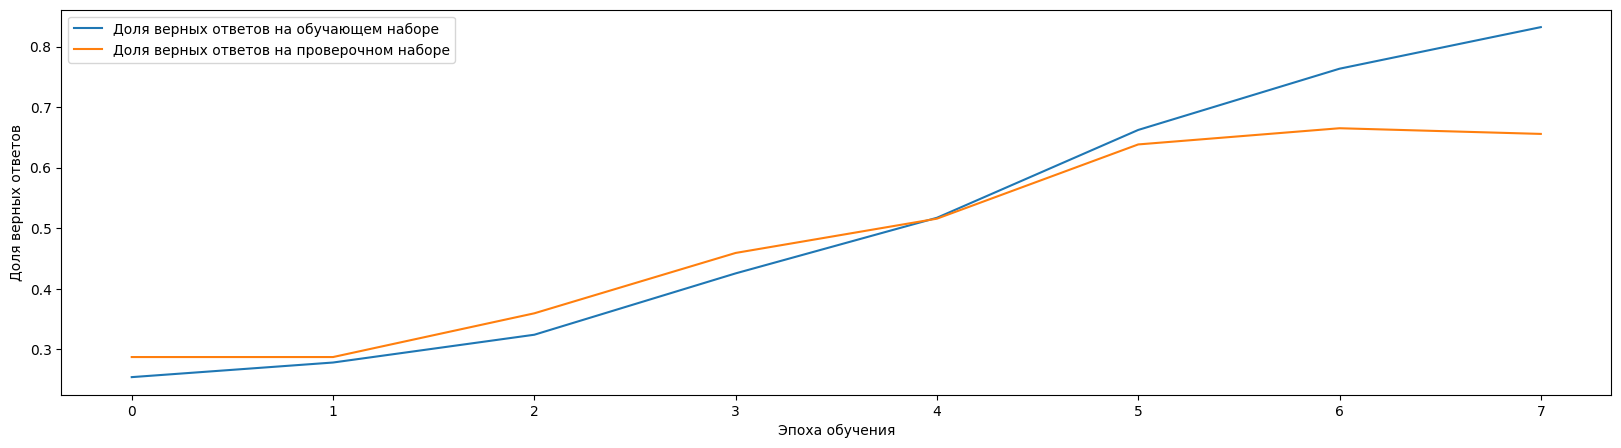

In [66]:
plt.figure(figsize=(20,5))
plt.plot(history_rnn.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_rnn.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Исследуем обученное плотное векторное представление слов

In [67]:
embedding_matrix_rnn = model_rnn.layers[0].get_weights()[0]
embedding_matrix_rnn[:5]

array([[-2.45056320e-02,  9.73763131e-03,  1.40325604e-02,
         5.89344166e-02,  5.82293868e-02, -5.29987663e-02,
         3.49844545e-02, -5.21260872e-03,  3.81538458e-02,
        -7.15537444e-02,  3.04599479e-02, -1.07113719e-02,
        -1.28783891e-02, -3.15944217e-02, -7.66099170e-02,
        -4.77954447e-02,  3.81929576e-02,  3.10350396e-02,
        -6.45925179e-02, -3.19527797e-02,  1.45344585e-02,
        -2.38193162e-02, -4.71767038e-02, -5.28489100e-03,
         2.27077659e-02, -5.58584407e-02,  8.32462609e-02,
         1.96660720e-02,  1.57256559e-01,  6.74281046e-02,
        -2.62766518e-02,  3.33757252e-02, -1.52669940e-02,
        -3.46073024e-02,  3.35418507e-02, -4.42321599e-02,
        -2.32082997e-02,  3.04767042e-02,  1.23206507e-02,
        -3.51819582e-02, -1.22882165e-02, -3.68970111e-02,
         4.16817740e-02,  1.04347710e-02, -1.09976947e-01,
         1.96544058e-03,  4.87066023e-02, -4.61108387e-02,
        -7.02730492e-02,  8.28806497e-03,  2.50369832e-0

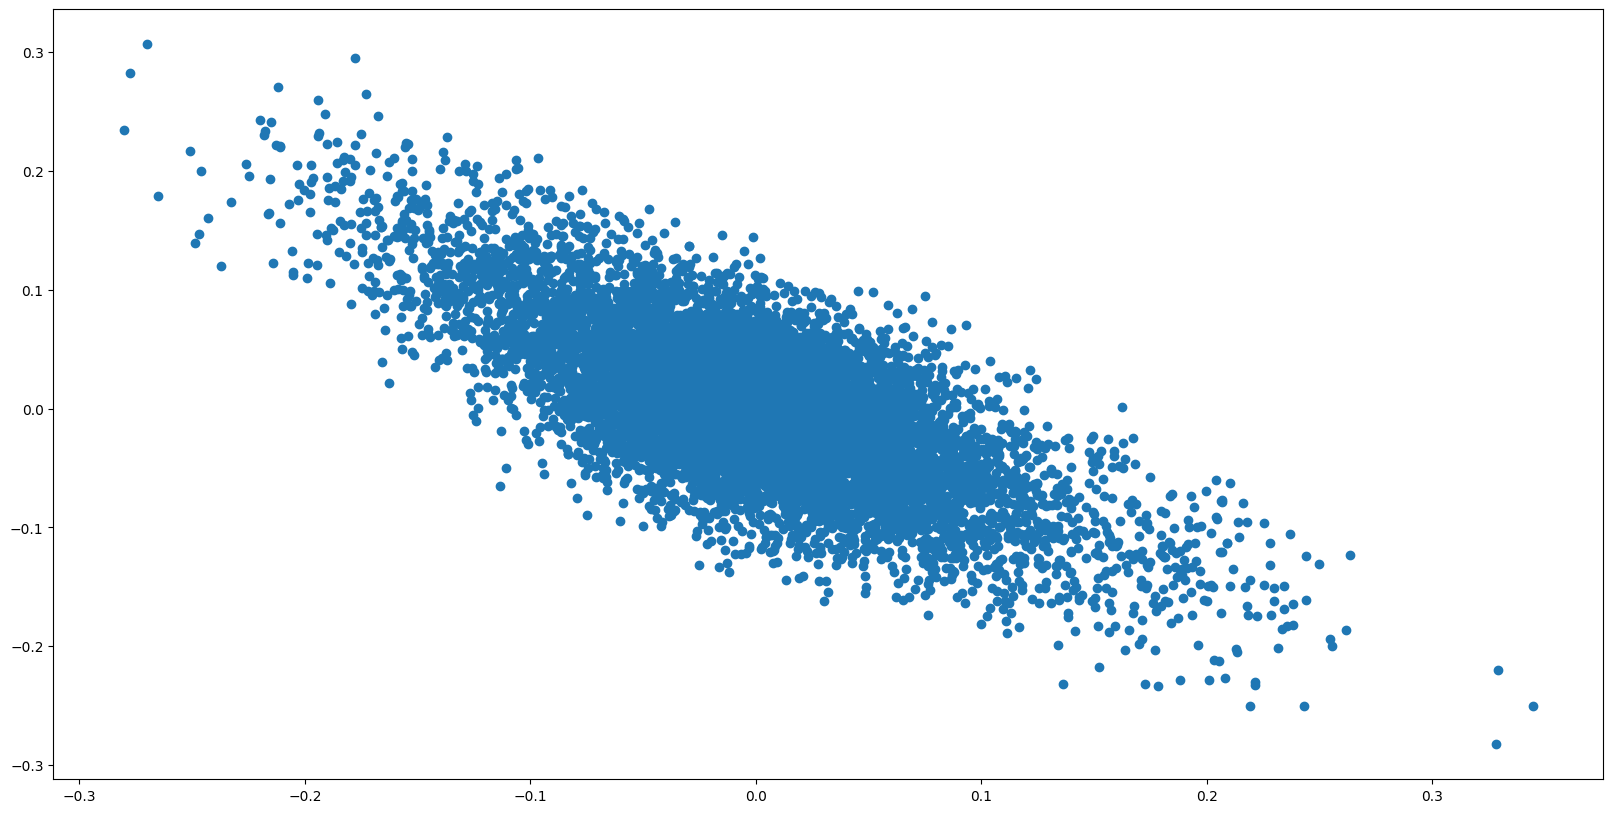

In [70]:
plt.figure(figsize=(20,10))
plt.scatter(embedding_matrix_rnn[:,0], embedding_matrix_rnn[:,1])

Обученное плотное векторное представление слов, характеризующих тональность текста

In [71]:
keywords = (class_keywords[forw_mapping['Extremely Positive']] +
            class_keywords[forw_mapping['Extremely Negative']] +
            class_keywords[forw_mapping['Negative']] +
            class_keywords[forw_mapping['Positive']])
keyword_codes=[]
new_keywords=[]
for word in keywords:
    code=word_to_index_dict.get(word,1)
    if code>1:
        keyword_codes.append(code)
        new_keywords.append(word)

print(keyword_codes)
print(new_keywords)

[3532, 748, 2603, 2295, 4180, 1690, 4581, 352, 591, 895, 3186, 2814, 2645, 1994, 78, 141, 662, 426, 2544, 191, 658]
['fantastic', 'amazing', 'incredible', 'wonderful', 'extraordinary', 'disaster', 'appalling', 'bad', 'worse', 'worst', 'terrible', 'awful', 'horrible', 'hate', 'good', 'great', 'happy', 'love', 'excellent', 'best', 'nice']


Получаем векторное представление интересующих нас слов

In [72]:
text_vectors = embedding_matrix_rnn[keyword_codes]

Визуализация обученного плотного векторного представления слов, по которым можно определить эмоциональную окраску текста

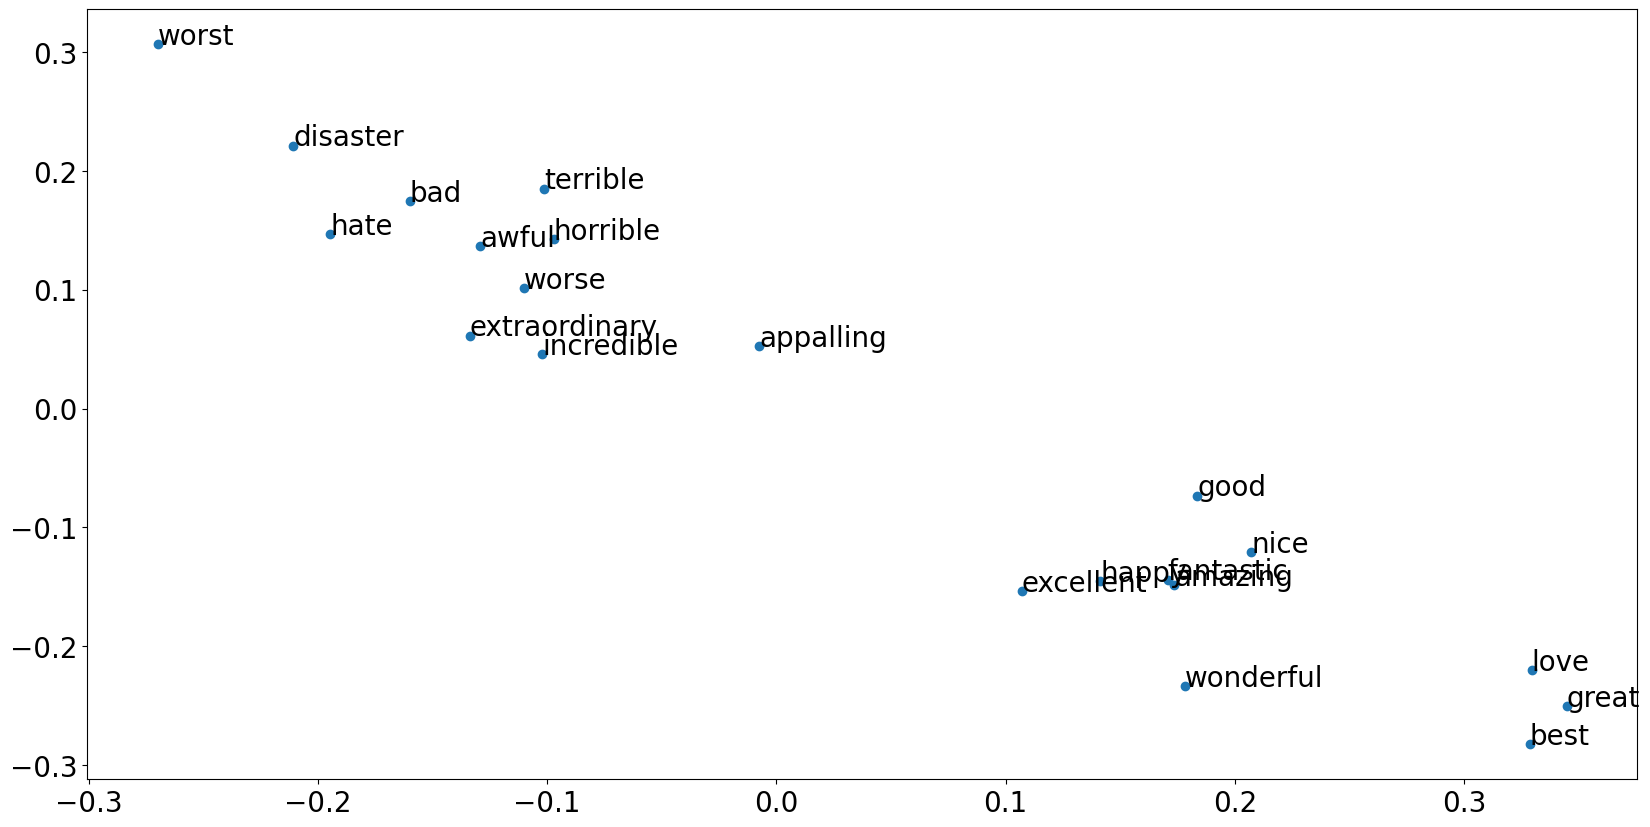

In [73]:
plt.figure(figsize=(20,10))
plt.rc('font', size=20)
plt.scatter(text_vectors[:,0], text_vectors[:,1])
for i, txt in enumerate(new_keywords):
    plt.annotate(txt, (text_vectors[i,0], text_vectors[i,1]))

## 10.3. Классификация с помощью сети LSTM

In [77]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64, input_length=maxlen))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dropout(0.28))
model_lstm.add(Dense(nb_classes, activation='softmax'))

model_lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 64, 64)            640000    
                                                                 
 lstm_2 (LSTM)               (None, 64, 128)           98816     
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 5)                 85        
                                                                 
Total params: 760037 (2.90 MB)
Trainable params: 76003

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [138]:
model_lstm_save_path = LOCAL_URI + 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [79]:
history_lstm = model_lstm.fit(x_train_dl,
                    y_train_dl,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback_lstm])

Epoch 1/8
202/203 [============================>.] - ETA: 0s - loss: 1.4441 - accuracy: 0.3521
Epoch 1: val_accuracy improved from -inf to 0.53197, saving model to ./data/best_model_lstm2.h5
203/203 [==============================] - 16s 69ms/step - loss: 1.4440 - accuracy: 0.3523 - val_loss: 1.1675 - val_accuracy: 0.5320
Epoch 2/8
202/203 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.6246
Epoch 2: val_accuracy improved from 0.53197 to 0.67130, saving model to ./data/best_model_lstm2.h5
203/203 [==============================] - 13s 66ms/step - loss: 0.9565 - accuracy: 0.6247 - val_loss: 0.8762 - val_accuracy: 0.6713
Epoch 3/8
202/203 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.7550
Epoch 3: val_accuracy improved from 0.67130 to 0.73037, saving model to ./data/best_model_lstm2.h5
203/203 [==============================] - 14s 67ms/step - loss: 0.6933 - accuracy: 0.7549 - val_loss: 0.7609 - val_accuracy: 0.7304
Epoch 4/8
202/203 [===

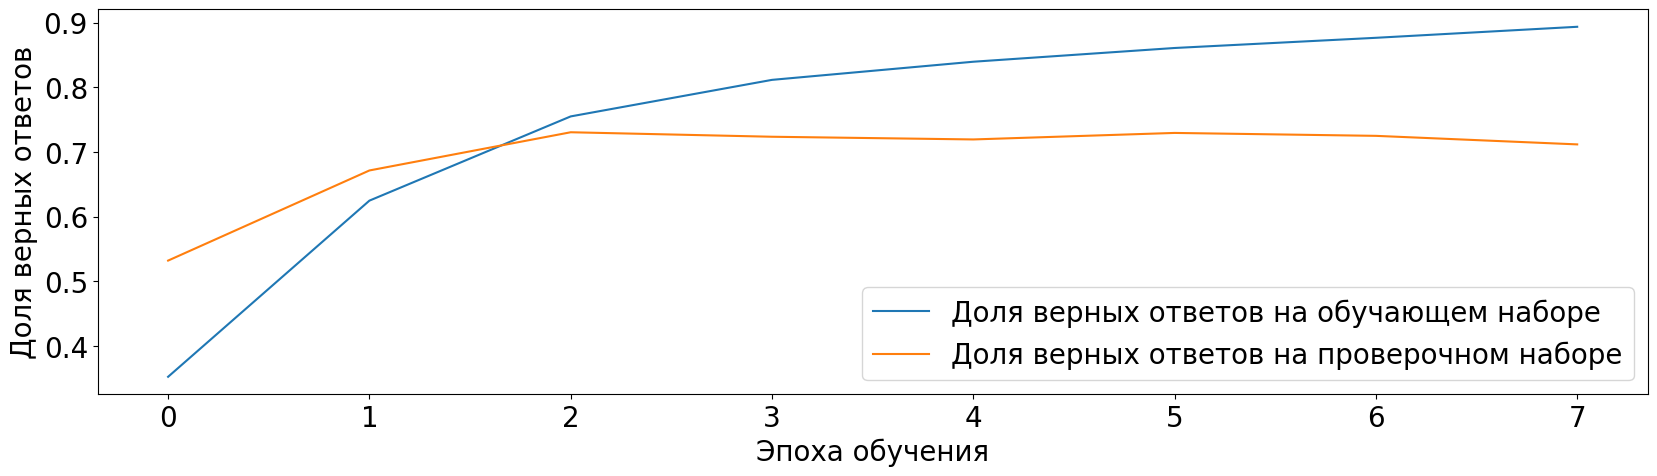

In [80]:
plt.figure(figsize=(20,5))
plt.plot(history_lstm.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_lstm.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## 10.4. Классификация с помощью сети GRU

In [95]:
model_gru = Sequential()
model_gru.add(Embedding(max_words, 64, input_length=maxlen))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(GRU(64, return_sequences=True))
model_gru.add(GRU(32, return_sequences=True))
model_gru.add(GRU(16))
model_gru.add(Dropout(0.28))
model_gru.add(Dense(nb_classes, activation='softmax'))

model_gru.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_gru.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 64, 64)            640000    
                                                                 
 gru_11 (GRU)                (None, 64, 128)           74496     
                                                                 
 gru_12 (GRU)                (None, 64, 64)            37248     
                                                                 
 gru_13 (GRU)                (None, 64, 32)            9408      
                                                                 
 gru_14 (GRU)                (None, 16)                2400      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_26 (Dense)            (None, 5)               

Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [144]:
model_gru_save_path = LOCAL_URI + 'best_model_gru.h5'
checkpoint_callback_gru = ModelCheckpoint(model_gru_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем нейронную сеть

In [97]:
history_gru = model_gru.fit(x_train_dl,
                    y_train_dl,
                    epochs=8,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback_gru])

Epoch 1/8
202/203 [============================>.] - ETA: 0s - loss: 1.3136 - accuracy: 0.4225
Epoch 1: val_accuracy improved from -inf to 0.61605, saving model to ./data/best_model_gru3.h5
203/203 [==============================] - 21s 87ms/step - loss: 1.3132 - accuracy: 0.4228 - val_loss: 0.9677 - val_accuracy: 0.6161
Epoch 2/8
202/203 [============================>.] - ETA: 0s - loss: 0.7970 - accuracy: 0.7095
Epoch 2: val_accuracy improved from 0.61605 to 0.71682, saving model to ./data/best_model_gru3.h5
203/203 [==============================] - 17s 83ms/step - loss: 0.7965 - accuracy: 0.7098 - val_loss: 0.7587 - val_accuracy: 0.7168
Epoch 3/8
202/203 [============================>.] - ETA: 0s - loss: 0.5943 - accuracy: 0.8097
Epoch 3: val_accuracy improved from 0.71682 to 0.73593, saving model to ./data/best_model_gru3.h5
203/203 [==============================] - 17s 83ms/step - loss: 0.5945 - accuracy: 0.8097 - val_loss: 0.7327 - val_accuracy: 0.7359
Epoch 4/8
202/203 [======

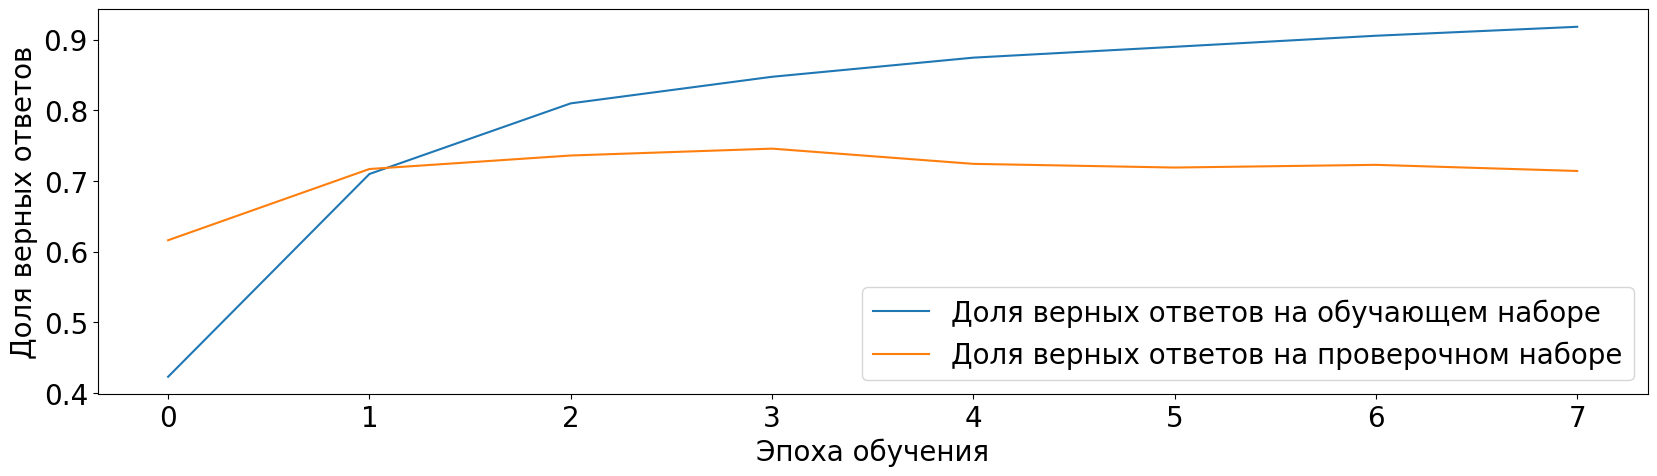

In [98]:
plt.figure(figsize=(20,5))
plt.plot(history_gru.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_gru.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## 10.4. Оценка качества работы сети на тестовом наборе данных

### Простая рекуррентная нейронная сеть

In [137]:
model_rnn.load_weights(model_rnn_save_path)
model_rnn.evaluate(x_test_dl, y_test_dl, verbose=1)

386/386 [==============================] - 1s 3ms/step - loss: 0.9760 - accuracy: 0.6226


[0.9760257005691528, 0.6226078271865845]

In [139]:
y_pred_rnn =np.argmax(model_rnn.predict(x_test_dl), axis=1)
f1_score_ml = f1_score(y_test, y_pred_rnn, average='weighted')
print('f1_score=', f1_score_ml)

386/386 [==============================] - 1s 3ms/step
f1_score= 0.6229520691549154


### Сеть LSTM

In [141]:
model_lstm.load_weights(model_lstm_save_path)
model_lstm.evaluate(x_test_dl, y_test_dl, verbose=1)

386/386 [==============================] - 4s 11ms/step - loss: 0.7387 - accuracy: 0.7408


[0.738692581653595, 0.7407557368278503]

In [142]:
y_pred_lstm =np.argmax(model_lstm.predict(x_test_dl), axis=1)
f1_score_ml = f1_score(y_test, y_pred_lstm, average='weighted')
print('f1_score=', f1_score_ml)

386/386 [==============================] - 5s 11ms/step
f1_score= 0.7414059723036883


### Сеть GRU

In [145]:
model_gru.load_weights(model_gru_save_path)
model_gru.evaluate(x_test_dl, y_test_dl, verbose=1)

386/386 [==============================] - 5s 14ms/step - loss: 0.7448 - accuracy: 0.7502


[0.744812548160553, 0.7502432465553284]

In [146]:
y_pred_gru =np.argmax(model_gru.predict(x_test_dl), axis=1)
f1_score_ml = f1_score(y_test, y_pred_gru, average='weighted')
print('f1_score=', f1_score_ml)

386/386 [==============================] - 6s 14ms/step
f1_score= 0.7514291649321697


### ВЫВОДЫ
Модель простой эвристики: accuracy = 0.28 f1_score= 0.13
Модель логистической регрессии и мешок слов accuracy = 0.62 f1_score= 0.62

Модель простой рекуррентной нейронной сети: accuracy = 0.6226 f1_score= 0.6229
Модель рекуррентной нейронной сети LSTM: accuracy = 0.7408 f1_score= 0.7414
Модель рекуррентной нейронной сети GRU: accuracy = 0.7502 f1_score= 0.7514

Модель простой рекуррентной нейронной сети по качеству соответствует модели логистической регрессии, однако сложнее
в реализации и дрльше обучается.
Модели рекуррентной нейронной сети LSTM и GRU обеспечивают более высокое качество, чем предыдущие методы, однако они еще сложнее в реализации и еще дольше обучаются.

Самый лучший результат показала модель рекуррентной нейронной сети GRU.